In [7]:
import geopandas
import requests
import datetime
import calendar
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import opendatasets as od
import plotly.express as px

from zipfile import ZipFile
from urllib.request import urlopen
from io import BytesIO
from google.cloud import bigquery
from prophet import Prophet

In [8]:
# Functions

# generates url for specific location to get sunset and sunrise data from "api.sunrisesunset.io"
# takes latitude, longitude and date 
# returns url
def url_generator(lat, lon, date):
    url = f'https://api.sunrisesunset.io/json?lat={str(lat)}&lng={str(lon)}&timezone=UTC&date={date}'
    return url


# gets geographic center point of a city in Turkey from "data.humdata.org"
# takes name of the city
# returns latitude and longitude
def get_tr_city_cp(city):
    humdata_url = 'https://data.humdata.org/dataset/ac768a5c-db29-4872-9792-bd3179e29c45/resource/b1d18b54-7175-4d32-85e9-a4710509dbfb/download/turkey_centeralpoints_1_2.zip'
    turkey_centeralpoints = geopandas.read_file(humdata_url)[['adm1_en', 'latitude', 'longitude']]
    turkey_centeralpoints = turkey_centeralpoints.rename(columns={'adm1_en': 'city'})
    
    [lat, long] = turkey_centeralpoints[turkey_centeralpoints['city'] == city][['latitude', 'longitude']].iloc[0]

    return lat, long


# converts time to minutes 
# takes time
# returns total minutes
def total_mins(time):
    s = datetime.timedelta(hours = time.hour,
                            minutes = time.minute)
    mins = s.total_seconds() / 60
    return mins


# generates a dataframe with columns of daily sunrise, sunset, and solar_moon times for the year 2022 
# takes name of the city
# returns dataframe
def get_sunset_sunrise(city):
    df = pd.DataFrame(columns = ['date', 'sunrise', 'sunset', 'solar_noon', 'sunrise(minutes)', 'sunset(minutes)', 'solar_noon(minutes)'])

    city_lat, city_long = get_tr_city_cp(city)
    start_date = datetime.date(2022, 1, 1)
    end_date = datetime.date(2022, 12, 31)

    delta = datetime.timedelta(days=1)
    while (start_date <= end_date):
        date_url = url_generator(city_lat, city_long, f'{start_date.year}-{start_date.month}-{start_date.day}')
        req = requests.get(date_url).json()['results']

        sunrise = req['sunrise']
        sunset = req['sunset']
        solarnoon = req['solar_noon']

        date = datetime.datetime(start_date.year, start_date.month, start_date.day)
        sunrise = datetime.datetime.strptime(sunrise[:-3], '%H:%M:%S') 
        sunset = datetime.datetime.strptime(sunset[:-3], '%H:%M:%S')
        solarnoon = datetime.datetime.strptime(solarnoon[:-3], '%H:%M:%S')

        sunrise += datetime.timedelta(hours=3)
        sunset += datetime.timedelta(hours=12+3)
        solarnoon += datetime.timedelta(hours=3)

        sunrise_mins = total_mins(sunrise)
        sunset_mins = total_mins(sunset)
        solarnoon_mins = total_mins(solarnoon)

        new_row = pd.DataFrame([[date, sunrise, sunset, solarnoon, sunrise_mins, sunset_mins, solarnoon_mins]],
                            columns=['date', 'sunrise', 'sunset', 'solar_noon', 'sunrise(minutes)', 'sunset(minutes)', 'solar_noon(minutes)'])

        df = pd.concat([df, new_row])

        start_date += delta

    return df


# visualizes the annual sunrise, sunset, and solar_noon times for a specific city in Turkey
# takes name of the city and subplot ax
def plot_sunrise_sunset(city, ax):
    df = get_sunset_sunrise(city)

    ax.plot(np.arange(0, 365), df['sunrise(minutes)'], label='sunrise')
    ax.plot(np.arange(0, 365), df['sunset(minutes)'], label='sunset')
    ax.plot(np.arange(0, 365), df['solar_noon(minutes)'], label='solar_noon')
    ax.axhline(y=8*60, color='red', linewidth=3, label='08:00')

    ax.grid()

    ax.set_ylabel('Time')
    ax.set_title(city)
    ax.legend()

    ax.set_xticks(np.arange(0, 365, step=31))
    ax.set_xticklabels(calendar.month_name[1:], rotation=30)

    ax.set_yticks(np.arange(0, 24*60, step=60*2))
    ax.set_yticklabels(np.arange(0, 24, step=2))


# generates one year data of daily traffic accidents in US as dataframe  
# takes year (2015 or 2016)
# returns dataframe
def get_us_accidents_data_by_year(year):
    s = f'bigquery-public-data.nhtsa_traffic_fatalities.accident_{year}'
    query = f'''
        SELECT COUNT(consecutive_number) AS accidentsCount,
               EXTRACT(DAY FROM timestamp_of_crash) AS day,
               EXTRACT(MONTH FROM timestamp_of_crash) AS month,
               EXTRACT(YEAR FROM timestamp_of_crash) AS year,   
               EXTRACT(DATE FROM timestamp_of_crash) AS date,
               EXTRACT(DAYOFWEEK FROM timestamp_of_crash) AS weekday
        FROM `{s}`
        GROUP BY date, year, month, day, weekday
        ORDER BY date
        '''

    client = bigquery.Client()

    query_job = client.query(query)
    accidents_by_date = query_job.to_dataframe()

    return accidents_by_date


# generates a new dataframe for a specific day from the given dataframe
# takes dataframe, day and month (or whole date)
# returns dataframe for 
def get_data_by_date(df, day = 1, month = 1, date = ''):
    if date != '':
        day, month, year = [int(x) for x in date.split('-')]

    data_by_date = (df[(df['day'] == day) &
                       (df['month'] == month)])

    return data_by_date


# visualizes the annual number of accidents in the US for a given year
# takes subplots ax and year
def plot_accidents_by_date(ax, year):
    if year == 2015:
        accidents = get_us_accidents_data_by_year(2015)
        # 8 Mar 2015 - Daylight Saving Time Started
        dst_started = get_data_by_date(accidents, day=8+1, month=3)
        # 1 Nov 2015 - Daylight Saving Time Ended
        dst_ended = get_data_by_date(accidents, day=1+1, month=11)
    elif year == 2016:
        accidents = get_us_accidents_data_by_year(2016)
        # 13 Mar 2016 - Daylight Saving Time Started
        dst_started = get_data_by_date(accidents, day=13+1, month=3)
        # 6 Nov 2016 - Daylight Saving Time Ended
        dst_ended = get_data_by_date(accidents, day=6+1, month=11)

    monday_mean = accidents[accidents['weekday'] == 2]['accidentsCount'].mean()
        
    ax.plot(accidents.index, accidents['accidentsCount'])
    ax.scatter(dst_started.index,
               dst_started['accidentsCount'],
               color='green',
               s = 150,
               label='dst started')
    ax.scatter(dst_ended.index,
               dst_ended['accidentsCount'],
               color='red',
               s = 150,
               label='dst ended')
    ax.axhline(y=monday_mean,
               color='black',
               label = 'Monday mean')

    ax.set_ylabel('Number of accidents')
    ax.set_title(f'US Traffic Accidents ({year})',
                 fontweight = 'bold',
                 fontsize = 20)
    ax.set_xticks(np.arange(0, 365, step=31))
    ax.set_xticklabels(calendar.month_name[1:], rotation=30)
    ax.legend()


# visualizes the average number of accidents according to the weekdays using a bar chart
# takes subplots ax and year
def plot_weekday_means(ax, year):
    weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    accidents = get_us_accidents_data_by_year(year)
    means = accidents.groupby('weekday',  as_index=False)['accidentsCount'].mean()

    ax.bar(weekdays, means['accidentsCount'])
    ax.set_title(f'Number of accidents by weekday ({year})')

# generates quantiles of the number of accidents that occur on Monday's for a given year
# takes year and quantiles
# returns a dataframe with quantiles
def monday_accidents_quantiles(year, quantiles):
    accidents = get_us_accidents_data_by_year(year)
    monday_accidents = accidents[accidents["weekday"] == 2]

    quantiles_df = monday_accidents[['accidentsCount']].quantile(quantiles)

    return quantiles_df

## Analysis of Turkey's Decision to Stay Permanently in Summer Time 
### Turkey Population Density Map
In 2016 Turkey decided to remain permanently in the summertime. Although some studies (["Daylight Saving Time policy and energy consumption, Sinan Küfeoğlu et al."](https://www.sciencedirect.com/science/article/pii/S2352484721006272#fig2)) have shown that daylight saving time is unnecessary, this decision was highly criticized by the public. Turkey's decision to remain permanently in the summertime has also been highly criticized because, considering the location of Turkey, it would be more logical to choose wintertime permanently. Let's analyze and decide which timezone (summer or winter) is better to remain permanently for Turkey.

In [9]:
tuik_url = 'https://data.tuik.gov.tr/Bulten/DownloadIstatistikselTablo?p=OW4kk4KIauRVHwQK9tma/jlD055DCNYc4XuRAZwpy550wSt7B4cANX305nVsp//V'
tuik_pop = pd.read_excel(tuik_url)

In [10]:
turkey_2021_pop = tuik_pop.iloc[4:85, [0, 22]].reset_index(drop = True)
turkey_2021_pop.columns = ['city', 'population']

In [11]:
turkey_2021_pop['city'] = turkey_2021_pop['city'].apply(lambda city : city.upper())
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('Ç', 'C')
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('Ğ', 'G')
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('İ', 'I')
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('Ö', 'O')
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('Ş', 'S')
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('Ü', 'U')

In [12]:
humdata_url1 = 'https://data.humdata.org/dataset/ac768a5c-db29-4872-9792-bd3179e29c45/resource/6cc83f12-885f-475b-98f7-9bad99d682b9/download/turkey_administrativelevels0_1_2.zip'
turkey_adm = geopandas.read_file(humdata_url1)[['adm1_en', 'geometry']]
turkey_adm = turkey_adm.rename(columns={'adm1_en': 'city'})

In [13]:
turkey_pop_geo = pd.merge(turkey_adm, turkey_2021_pop)

On this heatmap, we see the population density of cities in Turkey.

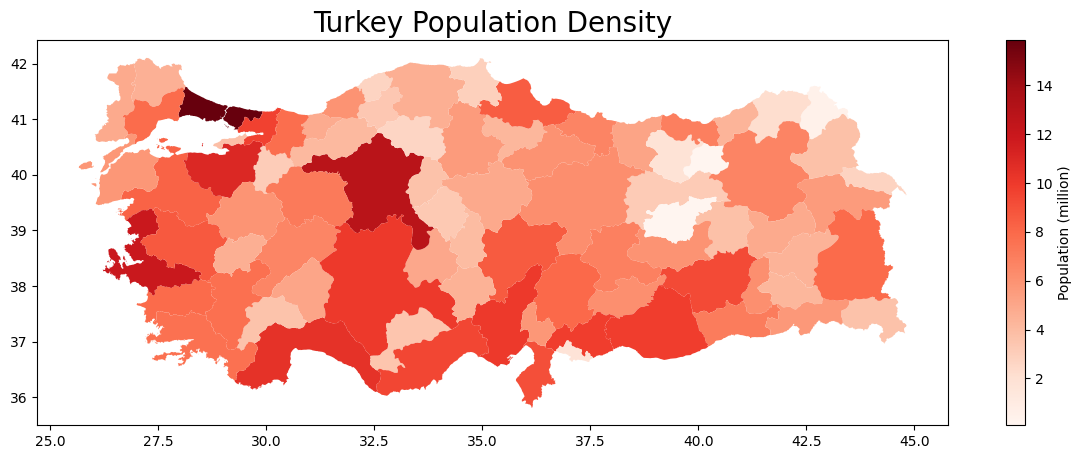

In [14]:
turkey_pop_geo['population(log())'] = np.log(turkey_pop_geo['population'])

fig, ax = plt.subplots(figsize=(15,5))
ax.set_title("Turkey Population Density", size=20)
turkey_pop_geo.plot(column="population(log())", cmap="Reds", ax=ax)
n = colors.Normalize(turkey_pop_geo.population.min()/1000000, turkey_pop_geo.population.max()/1000000)
cbar = plt.cm.ScalarMappable(norm=n, cmap="Reds")
ax_cbar = fig.colorbar(cbar, ax=ax)
ax_cbar.set_label("Population (million)")

### Population and Geographical Center Points of Turkey

Let's calculate the geographical and population center points of Turkey and analyze which meridian these points are closer to.

In [15]:
humdata_url2 = 'https://data.humdata.org/dataset/ac768a5c-db29-4872-9792-bd3179e29c45/resource/b1d18b54-7175-4d32-85e9-a4710509dbfb/download/turkey_centeralpoints_1_2.zip'
turkey_centeralpoints = geopandas.read_file(humdata_url2)[['adm1_en', 'latitude', 'longitude']]
turkey_centeralpoints = turkey_centeralpoints.rename(columns={'adm1_en': 'city'})

In [16]:
turkey_pop_lot_long = pd.merge(turkey_centeralpoints, turkey_2021_pop)

In [17]:
turkey_total_pop = turkey_2021_pop['population'].sum()

In [18]:
pop_cp_lat = np.sum(turkey_pop_lot_long['latitude']*turkey_pop_lot_long['population'])/turkey_total_pop
pop_cp_long = np.sum(turkey_pop_lot_long['longitude']*turkey_pop_lot_long['population'])/turkey_total_pop

df = pd.DataFrame({'latitude': [pop_cp_lat],'longitude': [pop_cp_long]})

pop_cp = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.longitude, df.latitude))

In [19]:
geo_cp_lat = (min(turkey_pop_lot_long['latitude']) + max(turkey_pop_lot_long['latitude'])) / 2
geo_cp_long = (min(turkey_pop_lot_long['longitude']) + max(turkey_pop_lot_long['longitude'])) / 2

df = pd.DataFrame({'latitude': [geo_cp_lat],'longitude': [geo_cp_long]})

geo_cp = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.longitude, df.latitude))

We can see that the population center point is clearly close to the 30th meridian, while the geopraghical center point is located in the middle of the two meridians (slightly closer to the 40th meridian).

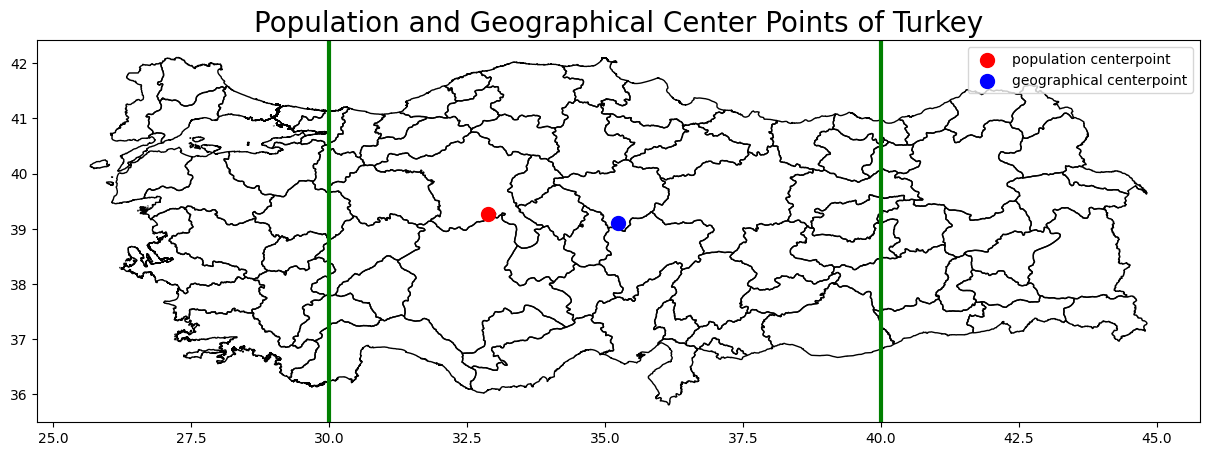

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))

turkey_adm.plot(ax = ax,edgecolor="k", facecolor="none")
pop_cp.plot(ax = ax, color='red', markersize = 100, label='population centerpoint')
geo_cp.plot(ax = ax, color='blue', markersize = 100, label='geographical centerpoint')
ax.axvline(x=30, color='green', linewidth=3)
ax.axvline(x=40, color='green', linewidth=3)

ax.set_title("Population and Geographical Center Points of Turkey", size=20)
ax.legend()

plt.show()

### Which cities are worst affected by the permanent summertime in Turkey?
Cities in the west will be most affected by the permanent summertime. We can find these cities by looking at the longitudes of the city center points. In winter, people in these cities wake up about an hour before sunrise and go to work or school.

In [21]:
turkey_centeralpoints['cpDistanceMeridian40'] = abs(turkey_centeralpoints['longitude']-40)

Top 5 most affected cities:

In [22]:
turkey_centeralpoints.sort_values(by='cpDistanceMeridian40', ascending=False)[:5]

,city,latitude,longitude,cpDistanceMeridian40
21,CANAKKALE,40.146498,26.406294,13.593706
27,EDIRNE,41.676425,26.552412,13.447588
40,IZMIR,38.434144,27.171866,12.828134
49,KIRKLARELI,41.735924,27.218857,12.781143
55,MANISA,38.622270,27.433657,12.566343


In [23]:
affected_df = pd.merge(turkey_adm, turkey_centeralpoints)

This is the map of the distances of the 40th meridian, which is taken as a basis in the permanent wintertime, to the cities. Considering that the population of the cities in the west is quite high, this is an important problem.

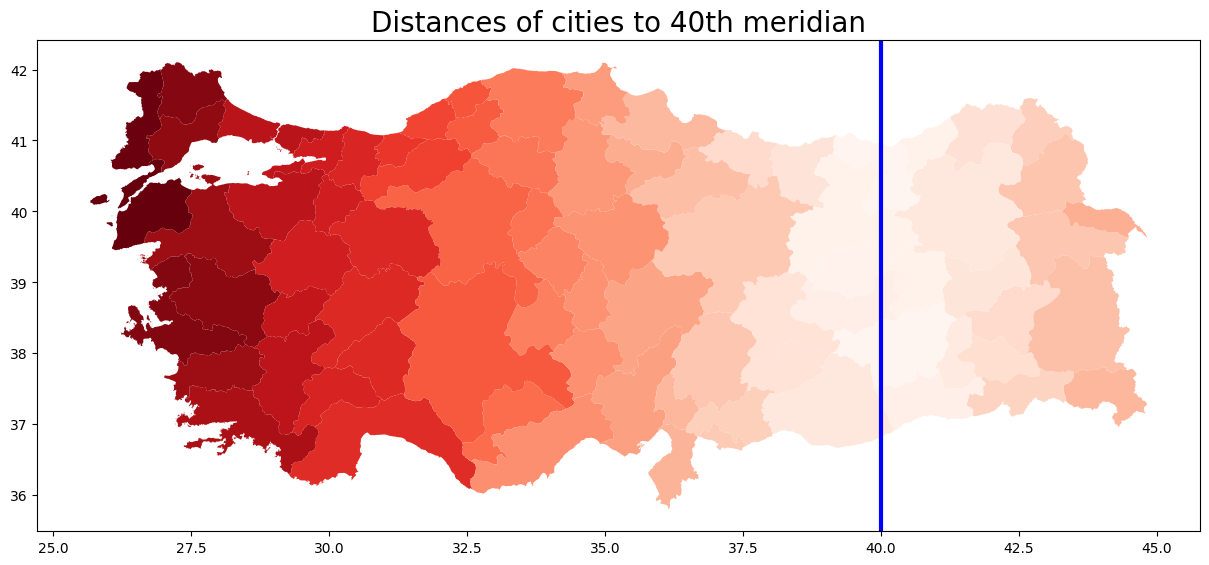

In [24]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Distances of cities to 40th meridian", size=20)
affected_df.plot(column='cpDistanceMeridian40', cmap="Reds", ax=ax)
ax.axvline(x=40, color='blue', linewidth=3)
plt.show()

### Preliminary results of the public consultation on time change in Europe (2018)
On 31 August 2018, the European Commission published the preliminary results of the public consultation on the time change. 

In [25]:
results = pd.DataFrame([['Austria', 0.77],
                        ['Belgium', 0.84],
                        ['Bulgaria', 0.84],
                        ['Croatia', 0.90],
                        ['Cyprus', 0.47],
                        ['Czechia', 0.83],
                        ['Denmark', 0.81],
                        ['Estonia', 0.85],
                        ['Finland', 0.95],
                        ['France', 0.84],
                        ['Germany', 0.84],
                        ['Greece', 0.44],
                        ['Hungary', 0.90],
                        ['Ireland', 0.88],
                        ['Italy', 0.66],
                        ['Latvia', 0.85],
                        ['Lithuania', 0.91],
                        ['Luxembourg', 0.79],
                        ['Malta', 0.54],
                        ['Netherlands', 0.79],
                        ['Poland', 0.95],
                        ['Portugal', 0.85],
                        ['Romania', 0.78],
                        ['Slovakia', 0.80],
                        ['Slovenia', 0.87],
                        ['Spain', 0.93],
                        ['Sweden', 0.88],
                        ['United Kingdom', 0.82]],
                        columns = ['country', 'abolish'])
results['keep'] = (1-results['abolish'])*100
results['abolish'] = results['abolish']*100

As seen here, almost all of the countries voted to abolish the daylight saving time.

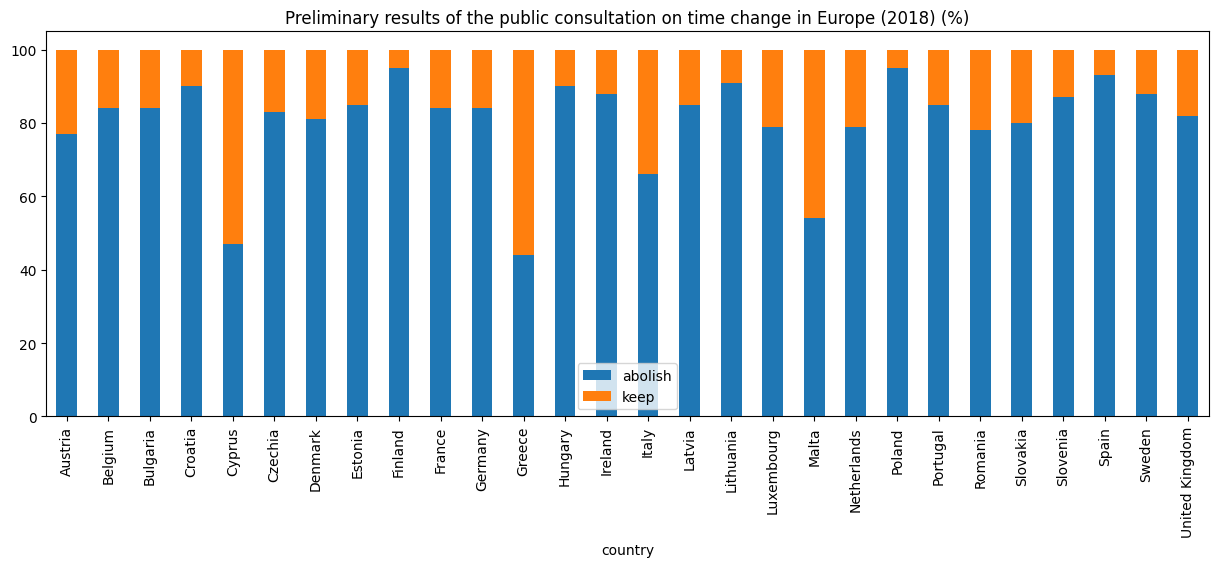

In [26]:
results.plot.bar(x = 'country', stacked='true', title='Preliminary results of the public consultation on time change in Europe (2018) (%)', figsize=(15, 5))
plt.show()

## Sunrise and Sunset Times for Cities in Turkey


* __Çanakkale__ -> western edge of Turkey
* __Yozgat__ -> geographical centerpoint of Turkey
* __Iğdır__ -> eastern edge of Turkey
* __Istanbul__ -> the most crowded city in Turkey

As seen below, the sun rises later in cities in the west. I showed 8 o'clock with a red line for every city.

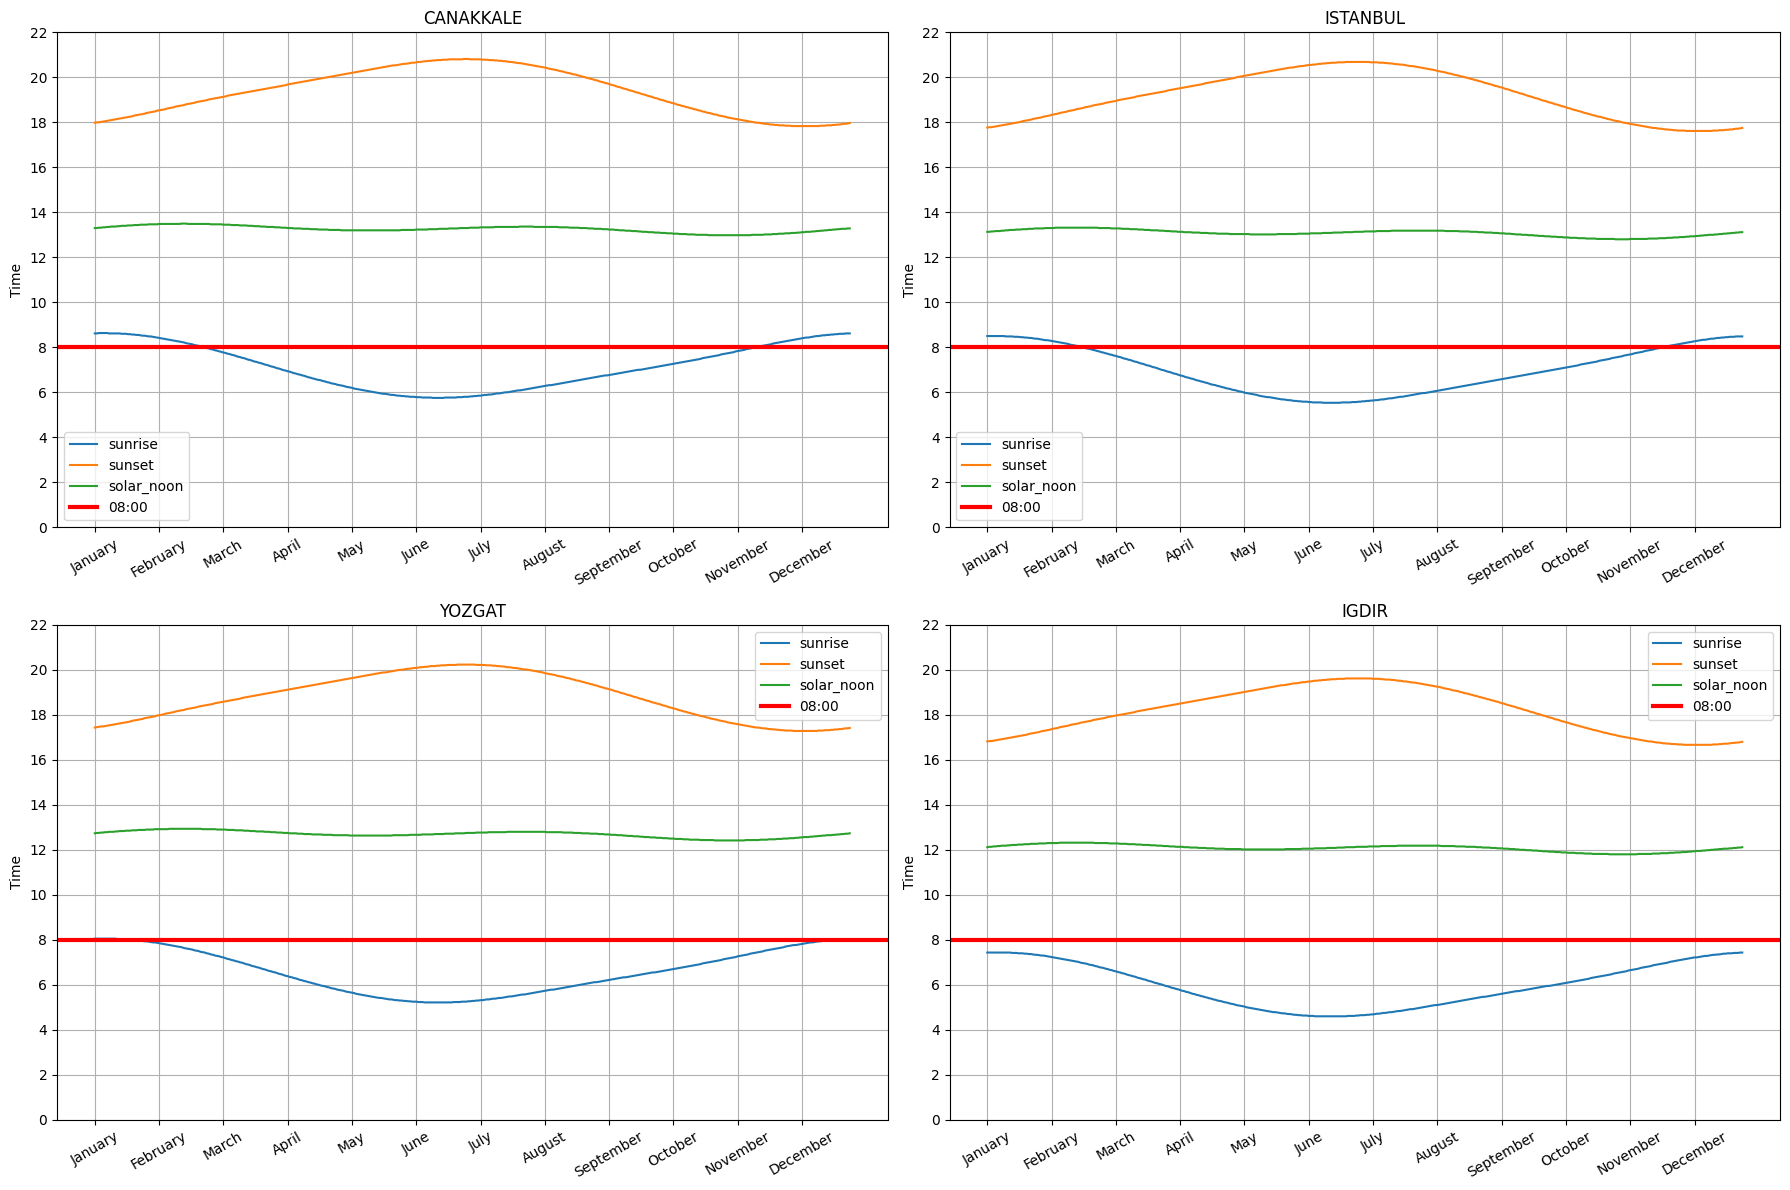

In [27]:
cities = ['CANAKKALE', 'ISTANBUL', 'YOZGAT', 'IGDIR']
x, y = 0, 0

fig, axs = plt.subplots(2, 2, figsize=(18,12))

for city in cities:
    if(y==2):
        y=0
        x+=1
    plot_sunrise_sunset(city, axs[x, y])
    y += 1

fig.tight_layout()

plt.show()

## US Traffic Accidents and Daylight Savings Time

* 2015: 
    * 8 March 2015 (Sunday) - Daylight Saving Time Started
    * 1 November 2015 (Sunday) - Daylight Saving Time Ended
* 2016:
    * 13 March 2016 (Sunday) - Daylight Saving Time Started
    * 6 November 2016 (Sunday) - Daylight Saving Time Ended

These dates show the days when the time changes for the daylight saving time were made. We'll analyze the following Mondays.

In [28]:
# You can get google application credenitals from https://console.cloud.google.com
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/Users/sahin/.google/mat388e-8b89c195b495.json'

Bar chart for the average number of accidents by weekdays for 2015 and 2016:

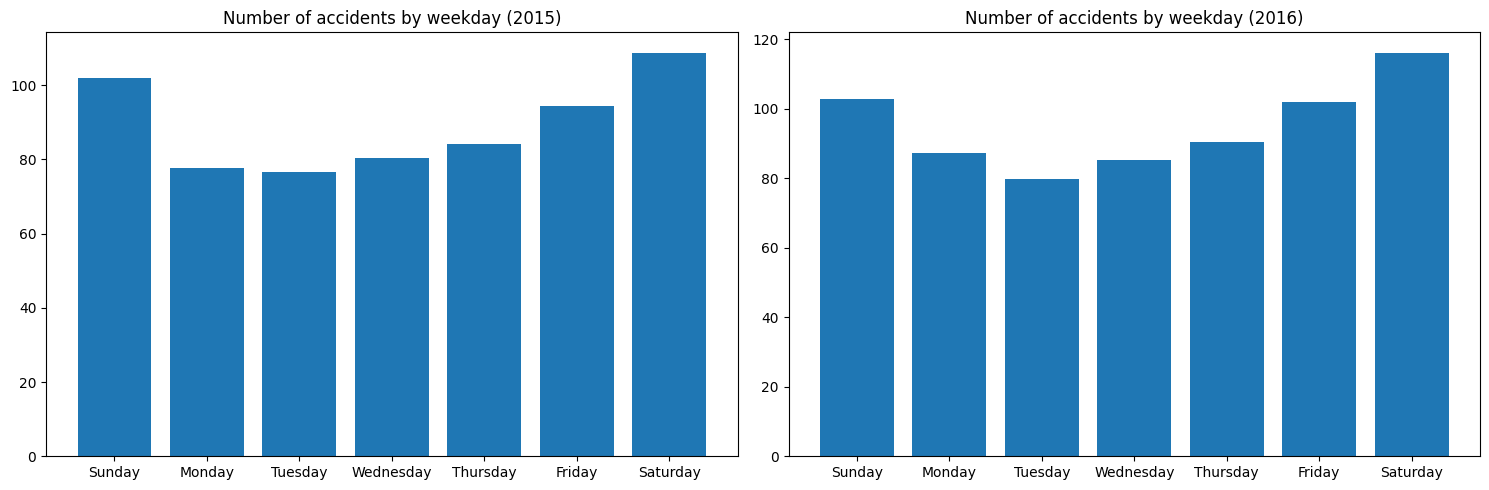

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_weekday_means(axs[0], year=2015)
plot_weekday_means(axs[1], year=2016)

fig.tight_layout()

plt.show()

I showed the number of accidents that occurred in two different years in separate graphs. I marked the days when the time changes for the DST were made and also added the average number of accidents on Mondays as a horizontal line. When we look at the graph for 2015, we see that both points are above the average. However on the graph for 2016, only one of the points is above average.

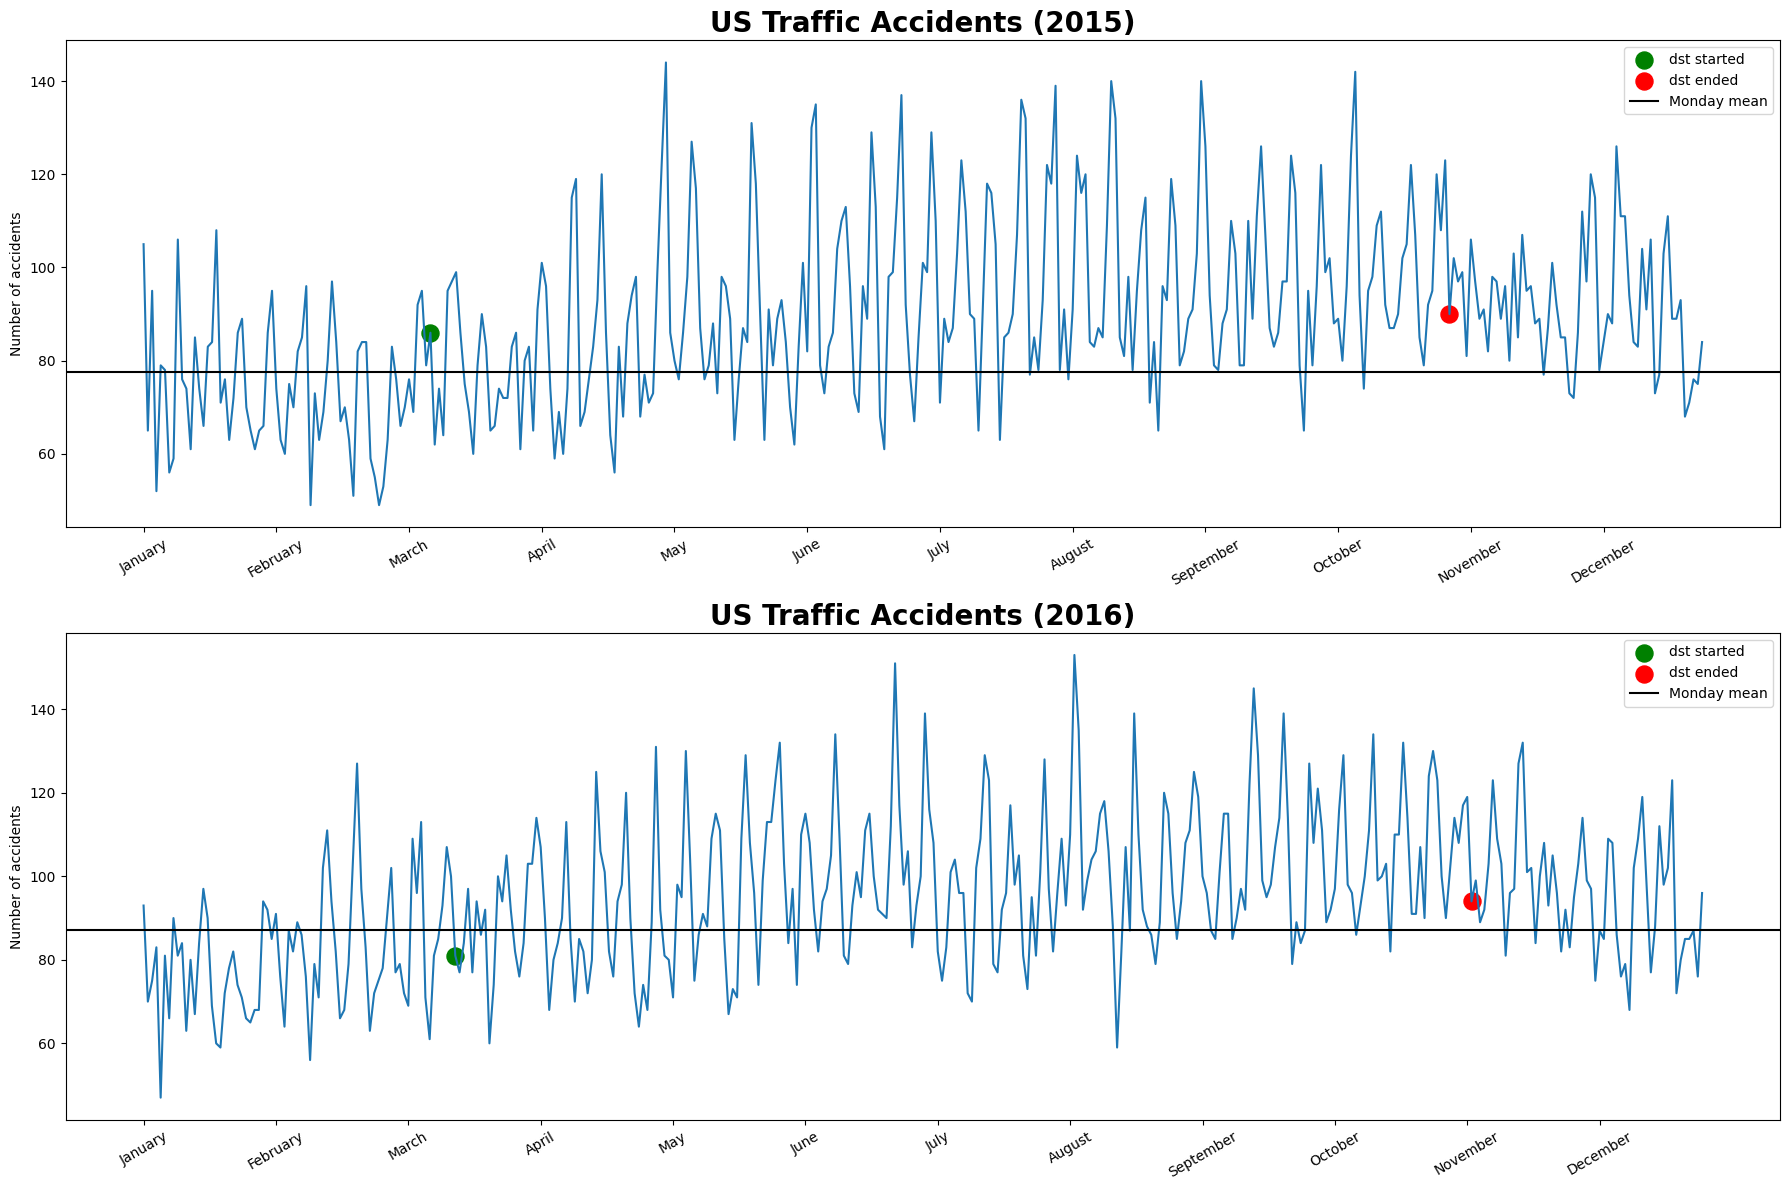

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(18,12))

plot_accidents_by_date(axs[0], year=2015)
plot_accidents_by_date(axs[1], year=2016)

fig.tight_layout()

plt.show()

I will use [Pandas dataframe.quantile()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.quantile.html) function to test whether daylight saving time is causing an increase in traffic accidents in the USA. This function returns values at the given quantile over requested axis.

For 2015, there were approximately 75% more accidents on the following Monday that DST started than on any other Monday, while the following Monday that DST ended there were approximately 90% more accidents than on any other Monday.

In [31]:
accidents_2015 = get_us_accidents_data_by_year(2015)

dst_started_2015 = get_data_by_date(accidents_2015, day=8+1, month=3)
dst_ended_2015 = get_data_by_date(accidents_2015, day=1+1, month=11)

print(f'Number of accidents when dst started for 2015: {dst_started_2015["accidentsCount"].iloc[0]}')
print(f'Number of accidents when dst ended for 2015: {dst_ended_2015["accidentsCount"].iloc[0]}')

monday_accidents_quantiles(2015, [.25, .5, .75, .90])

Number of accidents when dst started for 2015: 86
Number of accidents when dst ended for 2015: 90


,accidentsCount
0.25,68.0
0.50,78.5
0.75,87.0
0.90,90.0


For 2015, there were approximately 90% more accidents on the following Monday that DST started than on any other Monday, while the following Monday that DST ended there were approximately 75% more accidents than on any other Monday.

In [32]:
accidents_2016 = get_us_accidents_data_by_year(2016)

dst_started_2016 = get_data_by_date(accidents_2016, day=13+1, month=11)
dst_ended_2016 = get_data_by_date(accidents_2016, day=6+1, month=11)

print(f'Number of accidents when dst started for 2016: {dst_started_2016["accidentsCount"].iloc[0]}')
print(f'Number of accidents when dst ended for 2016: {dst_ended_2016["accidentsCount"].iloc[0]}')

monday_accidents_quantiles(2016, [.25, .5, .75, .90])

Number of accidents when dst started for 2016: 103
Number of accidents when dst ended for 2016: 94


,accidentsCount
0.25,79.75
0.50,86.5
0.75,96.25
0.90,100.9


### Anomaly Detection Model on US Traffic Accidents

I used [Prophet](https://facebook.github.io/prophet/) to analyze anomalies in US Traffic Accidents. Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Reference for the code: [Anomaly Detection Model on NYC Taxi Demand](https://www.analyticsvidhya.com/blog/2021/12/anomaly-detection-model-using-facebook-prophet/)

In [33]:
accidents_2015_2016 = pd.concat([accidents_2015, accidents_2016])

I made this interactive graph of traffic accident numbers to see the two years (2015 & 2016) together.

In [34]:
fig = px.line(accidents_2015_2016.reset_index(), x='date', y='accidentsCount', title='US Traffic Accidents (2015 & 2016)')

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='2y', step="year", stepmode="backward"),
        ])
    )
)

I decided to analyze the anomalies only on Mondays because as I have shown before, the average number of accidents by weekdays can vary quite a lot. Also, changes for the daylight saving time are always on Sundays, and I'm analzing the following Mondays.

In [35]:
monday_accidents = accidents_2015_2016[accidents_2015_2016['weekday'] == 2]
monday_accidents_df = monday_accidents.reset_index()[['date', 'accidentsCount']].rename({'date':'ds', 'accidentsCount':'y'}, axis='columns')

monday_accidents_df['ds']= pd.to_datetime(monday_accidents_df['ds'])

In [36]:
forecast_model = Prophet(changepoint_range=0.75)

forecast_model.fit(monday_accidents_df)

# periods = 7 because I want to skip 1 week
# freq = 'D' I'm looking at daily data 
futures = forecast_model.make_future_dataframe(periods=7, freq='D').iloc[:104]
forecasts = forecast_model.predict(futures)

17:59:03 - cmdstanpy - INFO - Chain [1] start processing
17:59:03 - cmdstanpy - INFO - Chain [1] done processing


I visualized forecast data.

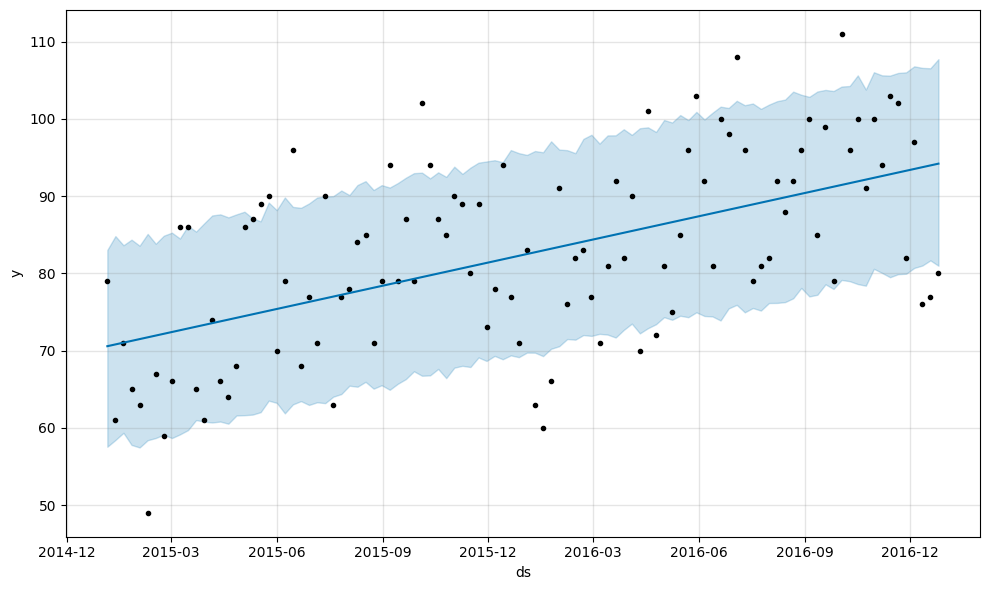

In [37]:
fig = forecast_model.plot(forecasts)

In [38]:
anomaly_df = pd.concat([monday_accidents_df.set_index('ds')['y'], forecasts.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)

anomaly_df['error'] = anomaly_df['y'] - anomaly_df['yhat']
anomaly_df['uncertainty'] = anomaly_df['yhat_upper'] - anomaly_df['yhat_lower']

I determined whether the values are anomalies by using the errors and uncertainties.

In [39]:
anomaly_df['anomaly'] = anomaly_df.apply(lambda x: 'Yes' if(np.abs(x['error']) > 0.5*x['uncertainty']) else 'No', axis = 1)

In this interactive graph, which I drew using "plotly", I showed the anomalies in the number of accidents on Mondays from January 2015 to December 2016. "9 March 2015" is shown as anomaly, but "2 Novermber 2015", "14 March 2016" and "7 November 2016" are not shown as anomalies.

In [40]:
#visualize the anomaly data
fig = px.scatter(anomaly_df.reset_index(), x='ds', y='y', color='anomaly', title='US Traffic Accidents by Mondays (2015 & 2016)')
#slider
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(step="all")
        ])
    )
)
fig.show()

__Final results on the analysis of the effects of DST on US Traffic Accidents:__ When I examined quantiles, I saw that DST significantly increased the number of accidents, but when I did anomaly detection, I could not get very successful results.